In [1]:
#@title Environment & Imports
import math, random, time, os, sys
from dataclasses import dataclass
from typing import Tuple, List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Colab basics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA:", torch.version.cuda, "| PyTorch:", torch.__version__)
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Device: cuda
CUDA: 12.6 | PyTorch: 2.8.0+cu126
GPU: NVIDIA A100-SXM4-40GB


In [2]:
#@title Configuration
from dataclasses import dataclass

@dataclass
class Config:
    H: int = 64
    W: int = 64

    # Channels: [RGB_LOGITS(3)] + [ALIVE_LOGIT(1)] + [HIDDEN] + [INSTR(3)] + [SPARE(1)]
    C_VISIBLE: int = 4
    C_HIDDEN: int = 16          # a bit more capacity helps stability/growth
    C_INSTR: int = 3
    C_SPARE: int = 1
    C_TOTAL: int = 4 + 16 + 3 + 1

    # Liquid gate (closed-form) hyperparams
    DELTA_MIN: float = 0.02

    # Training
    BATCH: int = 16
    LR: float = 2e-3
    WD: float = 1e-6
    MAX_ITERS_A: int = 1500
    MAX_ITERS_B: int = 800
    ROLLOUT_T_MIN: int = 48
    ROLLOUT_T_MAX: int = 96
    MID_LOSS_W: float = 0.30     # weight on mid-step loss

    # Damage
    DAMAGE_FRAC_MIN: float = 0.20
    DAMAGE_FRAC_MAX: float = 0.35
    DAMAGE_PUSH: float = 6.0

    # Loss weights
    LAMBDA_MSE: float = 1.0
    LAMBDA_TV: float = 0.02
    LAMBDA_ALIVE_MEAN: float = 1e-4
    LAMBDA_H_NORM: float = 0.001
    FG_WEIGHT: float = 8.0              # foreground up-weight for thin rings
    ALIVE_BCE_W: float = 0.7            # supervision on alive logit
    ALIVE_POS_WEIGHT: float = 6.0       # BCE pos_weight for thin foreground

    # Local update mask (from alive prob)
    ALIVE_THRESH: float = 0.10
    ALIVE_KAPPA: float = 10.0           # steepness of sigmoid around thresh
    LOGIT_LEAK: float = 0.01            # tiny decay on RGB logits per step

    # Geometry: fix for Day‑1 to learn a concrete rule first
    FIXED_GEOMETRY: bool = True
    RING_R: float = 0.55
    RING_TH: float = 0.10
    DIAMOND_R: float = 0.65
    DIAMOND_TH: float = 0.08
    BILOBE_R: float = 0.50
    BILOBE_D: float = 0.60
    BILOBE_TH: float = 0.10

    VIZ_STEPS: int = 64

cfg = Config()
print(cfg)


Config(H=64, W=64, C_VISIBLE=4, C_HIDDEN=16, C_INSTR=3, C_SPARE=1, C_TOTAL=24, DELTA_MIN=0.02, BATCH=16, LR=0.002, WD=1e-06, MAX_ITERS_A=1500, MAX_ITERS_B=800, ROLLOUT_T_MIN=48, ROLLOUT_T_MAX=96, MID_LOSS_W=0.3, DAMAGE_FRAC_MIN=0.2, DAMAGE_FRAC_MAX=0.35, DAMAGE_PUSH=6.0, LAMBDA_MSE=1.0, LAMBDA_TV=0.02, LAMBDA_ALIVE_MEAN=0.0001, LAMBDA_H_NORM=0.001, FG_WEIGHT=8.0, ALIVE_BCE_W=0.7, ALIVE_POS_WEIGHT=6.0, ALIVE_THRESH=0.1, ALIVE_KAPPA=10.0, LOGIT_LEAK=0.01, FIXED_GEOMETRY=True, RING_R=0.55, RING_TH=0.1, DIAMOND_R=0.65, DIAMOND_TH=0.08, BILOBE_R=0.5, BILOBE_D=0.6, BILOBE_TH=0.1, VIZ_STEPS=64)


In [3]:
#@title Utility: Targets, Seed, Losses, Damage
import torch.nn.functional as F

def make_coords(H, W, device=device):
    ys = torch.linspace(-1.0, 1.0, H, device=device).view(H, 1).expand(H, W)
    xs = torch.linspace(-1.0, 1.0, W, device=device).view(1, W).expand(H, W)
    return xs, ys

XS, YS = make_coords(cfg.H, cfg.W)

def target_ring(H: int, W: int, thickness: float, center, r: float):
    cx, cy = center
    dist = torch.sqrt((XS - cx)**2 + (YS - cy)**2)
    mask = (dist > (r - thickness)) & (dist < (r + thickness))
    return mask.float()

def target_diamond(H: int, W: int, thickness: float, center, r: float):
    cx, cy = center
    dist1 = (torch.abs(XS - cx) + torch.abs(YS - cy))
    mask = (dist1 > (r - thickness)) & (dist1 < (r + thickness))
    return mask.float()

def target_bilobe(H: int, W: int, thickness: float, center, r: float, d: float):
    cx, cy = center
    x1, y1 = cx - d/2, cy
    x2, y2 = cx + d/2, cy
    dist = torch.sqrt((XS - x1)**2 + (YS - y1)**2) + torch.sqrt((XS - x2)**2 + (YS - y2)**2)
    mask = (dist < (2*r + thickness)) & (dist > (2*r - thickness))
    return mask.float()

def _pix_to_norm(cx_pix: int, cy_pix: int, H: int, W: int):
    cx = 2.0 * (cx_pix / (W - 1)) - 1.0
    cy = 2.0 * (cy_pix / (H - 1)) - 1.0
    return cx, cy

def init_state(batch: int, cfg: Config, instr_onehot: torch.Tensor):
    """
    Returns:
      state:   (B, C_TOTAL, H, W) -> visible are LOGITS
      centers: (B, 2) normalized centers
    """
    B, H, W = batch, cfg.H, cfg.W
    state = torch.zeros((B, cfg.C_TOTAL, H, W), device=device)

    # Initialize background: dark & dead
    state[:, :3, :, :] = -4.0      # RGB logits ~ 0.018 prob
    state[:, 3:4, :, :] = -6.0     # ALIVE logit ~ 0.002 prob

    # Instruction broadcast (filled after we sample class)
    instr_grid = instr_onehot.view(B, cfg.C_INSTR, 1, 1).expand(B, cfg.C_INSTR, H, W)
    state[:, cfg.C_VISIBLE + cfg.C_HIDDEN : cfg.C_VISIBLE + cfg.C_HIDDEN + cfg.C_INSTR] = instr_grid

    centers = []
    for b in range(B):
        cx_pix = random.randint(8, W - 9)
        cy_pix = random.randint(8, H - 9)
        # Seed: alive on, RGB slightly positive to kick-start
        state[b, 3,  cy_pix-1:cy_pix+2, cx_pix-1:cx_pix+2] = 4.0
        state[b, :3, cy_pix-1:cy_pix+2, cx_pix-1:cx_pix+2] = 0.5
        state[b, -1, cy_pix-1:cy_pix+2, cx_pix-1:cx_pix+2] = 1.0  # spare seed mark
        centers.append(_pix_to_norm(cx_pix, cy_pix, H, W))

    centers = torch.tensor(centers, dtype=torch.float32, device=device)
    return state, centers

def sample_target_and_instr(batch: int, H: int, W: int, centers: torch.Tensor, device=device):
    imgs, instrs = [], []
    for i in range(batch):
        cx, cy = centers[i].tolist()
        k = random.randint(0, 2)
        if k == 0:
            if cfg.FIXED_GEOMETRY:
                g = target_ring(H, W, thickness=cfg.RING_TH, center=(cx, cy), r=cfg.RING_R)
            else:
                r = random.uniform(0.35, 0.60); th = random.uniform(0.08, 0.12)
                g = target_ring(H, W, thickness=th, center=(cx, cy), r=r)
        elif k == 1:
            if cfg.FIXED_GEOMETRY:
                g = target_diamond(H, W, thickness=cfg.DIAMOND_TH, center=(cx, cy), r=cfg.DIAMOND_R)
            else:
                r = random.uniform(0.50, 0.75); th = random.uniform(0.07, 0.12)
                g = target_diamond(H, W, thickness=th, center=(cx, cy), r=r)
        else:
            if cfg.FIXED_GEOMETRY:
                g = target_bilobe(H, W, thickness=cfg.BILOBE_TH, center=(cx, cy), r=cfg.BILOBE_R, d=cfg.BILOBE_D)
            else:
                r = random.uniform(0.45, 0.60); d = random.uniform(0.5, 0.7); th = random.uniform(0.08, 0.12)
                g = target_bilobe(H, W, thickness=th, center=(cx, cy), r=r, d=d)

        rgb = torch.stack([g, g, g], dim=0).to(device)
        imgs.append(rgb)
        instrs.append(torch.tensor([1,0,0] if k==0 else [0,1,0] if k==1 else [0,0,1],
                                   device=device, dtype=torch.float32))
    targets = torch.stack(imgs, dim=0)           # (B, 3, H, W) in {0,1}
    instr   = torch.stack(instrs, dim=0)         # (B, 3)
    return targets, instr

# Losses -----------------------------------------------------------------------

def weighted_mse(pred, target, fg_weight: float):
    fg = target[:, :1, :, :]
    w = 1.0 + fg_weight * fg
    return ((pred - target)**2 * w).mean()

def tv_loss(img):
    dx = img[:, :, 1:, :] - img[:, :, :-1, :]
    dy = img[:, :, :, 1:] - img[:, :, :, :-1]
    return (dx.abs().mean() + dy.abs().mean())

def hidden_norm_penalty(h):
    return (h**2).mean()

# Damage: push logits strongly negative in region
def apply_random_damage(state, cfg: Config, frac_range=(0.2, 0.35)):
    B, _, H, W = state.shape
    fmin, fmax = frac_range
    for b in range(B):
        fw = random.uniform(fmin, fmax); fh = random.uniform(fmin, fmax)
        ww = max(1, int(W * fw)); hh = max(1, int(H * fh))
        x0 = random.randint(0, W - ww); y0 = random.randint(0, H - hh)
        state[b, :3,  y0:y0+hh, x0:x0+ww] -= cfg.DAMAGE_PUSH
        state[b, 3:4, y0:y0+hh, x0:x0+ww] -= cfg.DAMAGE_PUSH
    return state


In [4]:
#@title Liquid Cell + Neighborhood
class Neighborhood(nn.Module):
    def __init__(self, C: int, k: int = 3, padding: int = 1):
        super().__init__()
        self.k = k
        self.padding = padding
        self.C = C
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        patches = F.unfold(x, kernel_size=self.k, padding=self.padding, stride=1)
        return patches.view(B, C*self.k*self.k, H, W)

class LiquidCell(nn.Module):
    """
    Visible channels are LOGITS: [rgb_logits(3), alive_logit(1)].
    We:
      - compute alive prob -> local update mask via softened 3x3 pooling
      - update hidden & visible only under that mask
      - apply tiny leak on RGB logits to avoid saturation
    """
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.neigh = Neighborhood(cfg.C_TOTAL, k=3, padding=1)

        Cn = cfg.C_TOTAL * 9
        Hh = cfg.C_HIDDEN
        Cv = cfg.C_VISIBLE

        self.Wx = nn.Conv2d(Cn, Hh, kernel_size=1, bias=True)
        self.Wh = nn.Conv2d(Hh, Hh, kernel_size=1, bias=False)
        self.Wg = nn.Conv2d(Cn + Hh, Hh, kernel_size=1, bias=True)
        self.Wout = nn.Conv2d(Hh + Cn, Cv, kernel_size=1, bias=True)

        for m in [self.Wx, self.Wh, self.Wg, self.Wout]:
            nn.init.xavier_uniform_(m.weight, gain=0.7)
            if m.bias is not None: nn.init.zeros_(m.bias)
        self.Wout.weight.data *= 0.25

        self.delta_min = cfg.DELTA_MIN
        self.kappa = cfg.ALIVE_KAPPA
        self.thresh = cfg.ALIVE_THRESH
        self.leak = cfg.LOGIT_LEAK

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        B, C, H, W = state.shape
        Cv, Hh = self.cfg.C_VISIBLE, self.cfg.C_HIDDEN

        neigh = self.neigh(state)         # (B, 9*C, H, W)
        logits = state[:, :Cv]            # (B, 4, H, W)
        rgb_logits = logits[:, :3]
        alive_logits = logits[:, 3:4]
        h = state[:, Cv:Cv+Hh]
        rest = state[:, Cv+Hh:]

        # Alive-based local update mask
        alive_prob = torch.sigmoid(alive_logits)
        avg_alive = F.avg_pool2d(alive_prob, kernel_size=3, stride=1, padding=1)
        update_mask = torch.sigmoid(self.kappa * (avg_alive - self.thresh))  # (B,1,H,W)

        # Hidden update (liquid gate) under mask
        h_tilde = torch.tanh(self.Wx(neigh) + self.Wh(h))
        delta_raw = torch.sigmoid(self.Wg(torch.cat([neigh, h], dim=1)))
        delta = delta_raw * (1 - 2*self.delta_min) + self.delta_min
        h_next = h + update_mask * delta * (h_tilde - h)

        # Visible logits update under mask (+ tiny leak on RGB)
        out_in = torch.cat([h_next, neigh], dim=1)
        dlogits = self.Wout(out_in)
        rgb_logits_next   = (1 - self.leak) * rgb_logits + update_mask * dlogits[:, :3]
        alive_logits_next = alive_logits + update_mask * dlogits[:, 3:4]

        new_visible = torch.cat([rgb_logits_next, alive_logits_next], dim=1)
        new_state = torch.cat([new_visible, h_next, rest], dim=1)
        return new_state


In [5]:
#@title Model Wrapper & Training Rollout
class LiquidMorphCA(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.cell = LiquidCell(cfg)

    @torch.no_grad()
    def step_no_grad(self, state: torch.Tensor, steps: int = 1):
        for _ in range(steps): state = self.cell(state)
        return state

    def step(self, state: torch.Tensor, steps: int = 1):
        for _ in range(steps): state = self.cell(state)
        return state

def compute_losses(state: torch.Tensor, target_rgb: torch.Tensor, cfg: Config):
    Cv, Hh = cfg.C_VISIBLE, cfg.C_HIDDEN
    rgb_logits = state[:, :3]
    alive_logits = state[:, 3:4]
    hidden = state[:, Cv:Cv+Hh]

    pred_rgb = torch.sigmoid(rgb_logits)
    alive_prob = torch.sigmoid(alive_logits)
    target_mask = target_rgb[:, :1]  # ring/edge mask in {0,1}

    # RGB reconstruction (foreground-weighted) + smoothness
    loss_rgb = weighted_mse(pred_rgb, target_rgb, cfg.FG_WEIGHT)
    loss_tv  = tv_loss(pred_rgb)

    # Alive supervision (BCE with class imbalance)
    pos_w = torch.tensor(cfg.ALIVE_POS_WEIGHT, device=state.device)
    loss_alive_sup = F.binary_cross_entropy_with_logits(alive_logits, target_mask, pos_weight=pos_w)

    # Regularizers
    loss_alive_mean = alive_prob.mean()
    loss_hnorm = hidden_norm_penalty(hidden)

    total = (cfg.LAMBDA_MSE * loss_rgb
             + cfg.LAMBDA_TV * loss_tv
             + cfg.ALIVE_BCE_W * loss_alive_sup
             + cfg.LAMBDA_ALIVE_MEAN * loss_alive_mean
             + cfg.LAMBDA_H_NORM * loss_hnorm)

    stats = {
        "loss_total": float(total.detach()),
        "loss_rgb": float(loss_rgb.detach()),
        "loss_tv": float(loss_tv.detach()),
        "loss_alive_sup": float(loss_alive_sup.detach()),
        "alive_mean": float(loss_alive_mean.detach()),
        "hnorm": float(loss_hnorm.detach()),
    }
    return total, stats

def rollout_training(model: LiquidMorphCA,
                     cfg: Config,
                     stage: str = "A",
                     optimizer: Optional[torch.optim.Optimizer] = None):
    model.train()
    B, H, W = cfg.BATCH, cfg.H, cfg.W

    dummy_instr = torch.zeros((B, cfg.C_INSTR), device=device)
    state, centers = init_state(B, cfg, dummy_instr)
    targets, instr = sample_target_and_instr(B, H, W, centers, device=device)

    # write instruction channels
    instr_grid = instr.view(B, cfg.C_INSTR, 1, 1).expand(B, cfg.C_INSTR, H, W)
    state[:, cfg.C_VISIBLE + cfg.C_HIDDEN : cfg.C_VISIBLE + cfg.C_HIDDEN + cfg.C_INSTR] = instr_grid

    T = random.randint(cfg.ROLLOUT_T_MIN, cfg.ROLLOUT_T_MAX)
    damage_step = random.randint(T//4, (2*T)//3) if stage == "B" else None
    mid_t = int(0.75 * T)
    state_mid = None

    for t in range(T):
        state = model.step(state, steps=1)
        if t == mid_t:
            state_mid = state
        if stage == "B" and t == damage_step:
            state = apply_random_damage(state, cfg, (cfg.DAMAGE_FRAC_MIN, cfg.DAMAGE_FRAC_MAX))

    loss_end, stats_end = compute_losses(state, targets, cfg)
    if state_mid is not None:
        loss_mid, _ = compute_losses(state_mid, targets, cfg)
        total = (1 - cfg.MID_LOSS_W) * loss_end + cfg.MID_LOSS_W * loss_mid
        stats_end["loss_mid"] = float(loss_mid.detach())
    else:
        total = loss_end

    if optimizer is not None:
        optimizer.zero_grad(set_to_none=True)
        total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    stats_end["T"] = T
    stats_end["loss_total"] = float(total.detach())
    return stats_end


In [6]:
#@title Visualization Helpers (UPDATED)
from IPython.display import clear_output

def _rgb_from_logits(rgb_logits: torch.Tensor):
    rgb = torch.sigmoid(rgb_logits).clamp(0,1)
    return rgb.permute(1,2,0).detach().cpu().numpy()

@torch.no_grad()
def render_growth(model: LiquidMorphCA,
                  cfg: Config,
                  pattern_idx: int = 0,
                  steps: int = 64,
                  damage_at: Optional[int] = None,
                  damage_frac=(0.25, 0.3),
                  show_alive: bool = False,
                  seed=None):
    if seed is not None:
        set_seed(seed)

    B, H, W = 1, cfg.H, cfg.W
    instr = torch.tensor([[1,0,0] if pattern_idx==0 else [0,1,0] if pattern_idx==1 else [0,0,1]],
                         dtype=torch.float32, device=device)
    state, centers = init_state(B, cfg, instr)
    cx, cy = centers[0].tolist()

    if pattern_idx == 0:
        g = target_ring(H, W, thickness=cfg.RING_TH, center=(cx, cy), r=cfg.RING_R)
    elif pattern_idx == 1:
        g = target_diamond(H, W, thickness=cfg.DIAMOND_TH, center=(cx, cy), r=cfg.DIAMOND_R)
    else:
        g = target_bilobe(H, W, thickness=cfg.BILOBE_TH, center=(cx, cy), r=cfg.BILOBE_R, d=cfg.BILOBE_D)
    target = torch.stack([g,g,g], dim=0).unsqueeze(0).to(device)

    instr_grid = instr.view(B, cfg.C_INSTR, 1, 1).expand(B, cfg.C_INSTR, H, W)
    state[:, cfg.C_VISIBLE + cfg.C_HIDDEN : cfg.C_VISIBLE + cfg.C_HIDDEN + cfg.C_INSTR] = instr_grid

    frames = []
    for t in range(steps):
        state = model.step_no_grad(state, steps=1)
        if damage_at is not None and t == damage_at:
            state = apply_random_damage(state, cfg, damage_frac)

        img = _rgb_from_logits(state[0, :3])
        if show_alive:
            alive = torch.sigmoid(state[0, 3:4]).repeat(3,1,1).permute(1,2,0).cpu().numpy()
            img = (0.8*img + 0.2*np.stack([alive[:,:,0], np.zeros_like(alive[:,:,0]), np.zeros_like(alive[:,:,0])], axis=-1))
        frames.append(img)

    fig, axes = plt.subplots(1, 3, figsize=(10,3))
    axes[0].imshow(frames[0]);        axes[0].set_title("Step 0"); axes[0].axis('off')
    axes[1].imshow(frames[steps//2]); axes[1].set_title(f"Step {steps//2}"); axes[1].axis('off')
    axes[2].imshow(frames[-1]);       axes[2].set_title(f"Step {steps-1}"); axes[2].axis('off')
    plt.show()

    return frames, target[0]


In [7]:
#@title Instantiate Model & Optimizer
model = LiquidMorphCA(cfg).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WD)
print("Parameters:", sum(p.numel() for p in model.parameters())/1e6, "M")


Parameters: 0.008388 M


[Stage A] iter=1500/1500 | T=67 | loss=0.0409 | 285.2s
  loss_rgb: 0.013797
  loss_tv: 0.055682
  loss_alive_sup: 0.032711
  loss_mid: 0.046817


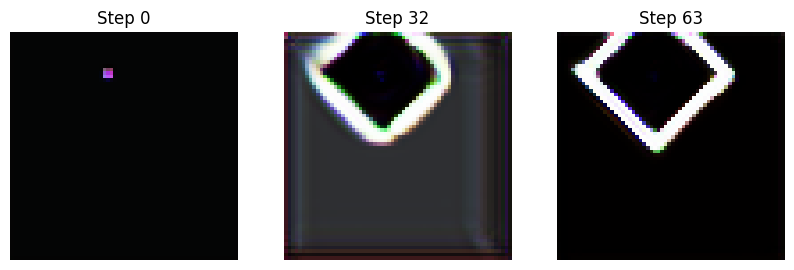

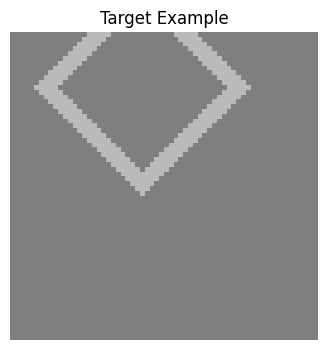

In [8]:
#@title Stage A Training (Growth)
loss_log_A = []
start = time.time()
for it in range(1, cfg.MAX_ITERS_A + 1):
    stats = rollout_training(model, cfg, stage="A", optimizer=optimizer)
    loss_log_A.append(stats["loss_total"])

    if it % 100 == 0 or it == 1:
        clear_output(wait=True)
        dt = time.time() - start

        # First iteration: print all available stats to see what we have
        if it == 1:
            print("Available stats:", stats.keys())

        # Simple version - just print what we have
        print(f"[Stage A] iter={it}/{cfg.MAX_ITERS_A} | T={stats['T']} | "
              f"loss={stats['loss_total']:.4f} | {dt:.1f}s")

        # Optional: print all loss components
        for key, val in stats.items():
            if key.startswith('loss_') and key != 'loss_total':
                print(f"  {key}: {val:.6f}")

        with torch.no_grad():
            frames, tgt = render_growth(model, cfg, pattern_idx=random.randint(0,2),
                                        steps=cfg.VIZ_STEPS, seed=it)
        plt.figure(figsize=(4,4))
        plt.imshow(_rgb_from_logits(tgt)); plt.title("Target Example"); plt.axis('off')
        plt.show()

Ring


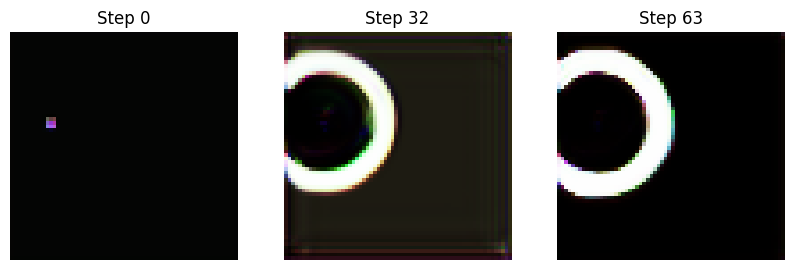

Diamond


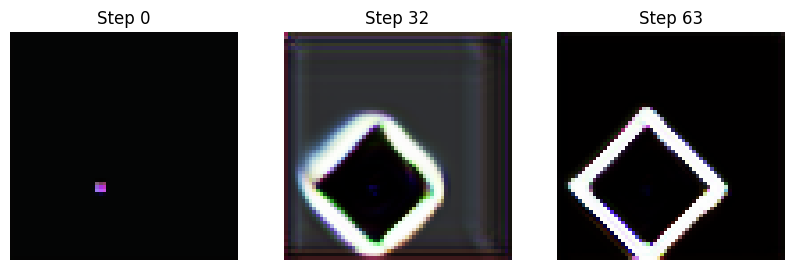

Bi-lobe


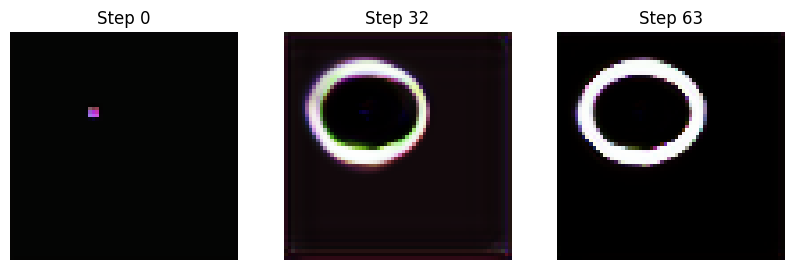

In [9]:
#@title Visual Check: Growth (No Damage)
with torch.no_grad():
    for k in range(3):
        print(["Ring","Diamond","Bi-lobe"][k])
        _ = render_growth(model, cfg, pattern_idx=k, steps=cfg.VIZ_STEPS, damage_at=None, seed=123+k)


[Stage B] iter=800/800 | T=81 | loss=0.0615 | 154.0s
  loss_rgb: 0.019991
  loss_tv: 0.062161
  loss_alive_sup: 0.062732
  loss_mid: 0.051347


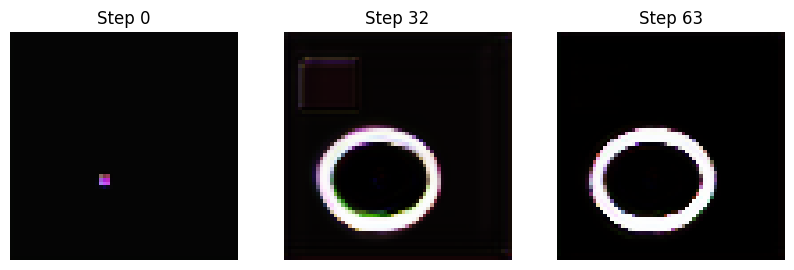

In [10]:
#@title Stage B Training (Regeneration)
loss_log_B = []
start = time.time()
for it in range(1, cfg.MAX_ITERS_B + 1):
    stats = rollout_training(model, cfg, stage="B", optimizer=optimizer)
    loss_log_B.append(stats["loss_total"])

    if it % 100 == 0 or it == 1:
        clear_output(wait=True)
        dt = time.time() - start

        # First iteration: print all available stats to see what we have
        if it == 1:
            print("Available stats:", stats.keys())

        # Simple version - just print what we have
        print(f"[Stage B] iter={it}/{cfg.MAX_ITERS_B} | T={stats['T']} | "
              f"loss={stats['loss_total']:.4f} | {dt:.1f}s")

        # Optional: print all loss components
        for key, val in stats.items():
            if key.startswith('loss_') and key != 'loss_total':
                print(f"  {key}: {val:.6f}")

        with torch.no_grad():
            frames, _ = render_growth(model, cfg, pattern_idx=random.randint(0,2),
                                      steps=cfg.VIZ_STEPS, damage_at=cfg.VIZ_STEPS//3,
                                      damage_frac=(cfg.DAMAGE_FRAC_MIN, cfg.DAMAGE_FRAC_MAX),
                                      seed=777+it)

Ring with mid-rollout damage


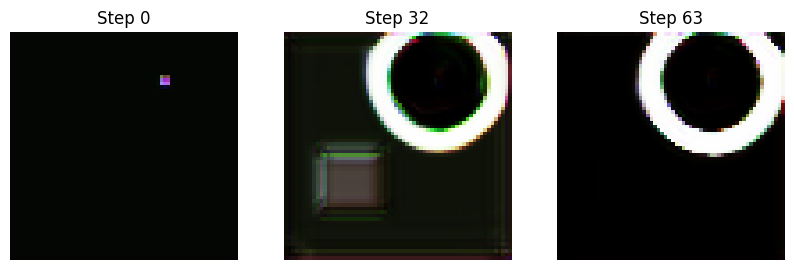

Diamond with mid-rollout damage


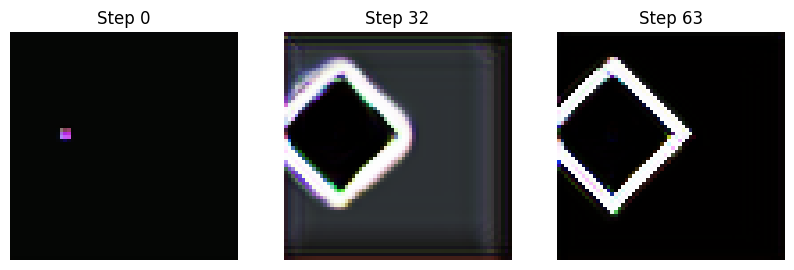

Bi-lobe with mid-rollout damage


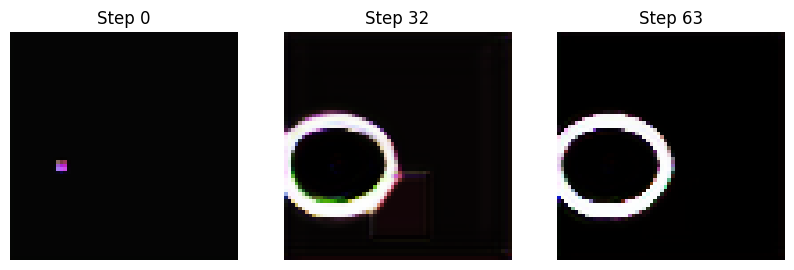

In [11]:
#@title Visual Check: Regeneration
with torch.no_grad():
    for k in range(3):
        print(["Ring","Diamond","Bi-lobe"][k], "with mid-rollout damage")
        _ = render_growth(model, cfg, pattern_idx=k, steps=cfg.VIZ_STEPS,
                          damage_at=cfg.VIZ_STEPS//3, damage_frac=(0.25, 0.3), seed=2025+k)


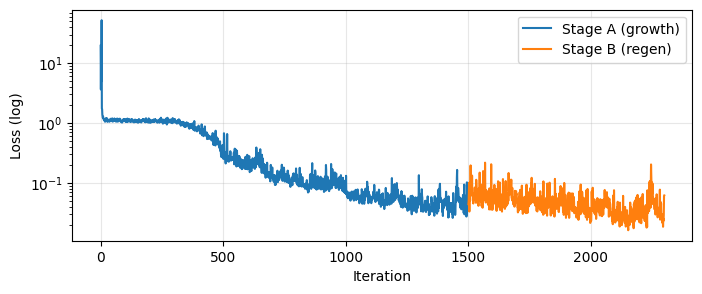

In [12]:
#@title Loss Curves
plt.figure(figsize=(8,3))
if len(loss_log_A):
    plt.plot(loss_log_A, label="Stage A (growth)")
if len(loss_log_B):
    plt.plot(range(len(loss_log_A), len(loss_log_A)+len(loss_log_B)), loss_log_B, label="Stage B (regen)")
plt.yscale('log')
plt.xlabel("Iteration"); plt.ylabel("Loss (log)"); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


Fixed-gate behavior (compare visually to liquid):


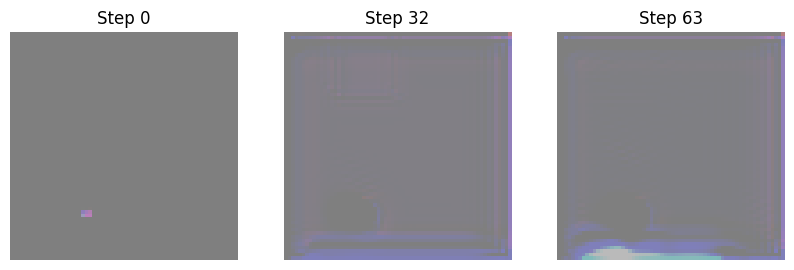

In [13]:
#@title (Optional) Ablation: Fixed Gate
class FixedGateCell(LiquidCell):
    def __init__(self, cfg: Config, alpha: float = 0.25):
        super().__init__(cfg)
        self.alpha = alpha
    def forward(self, state):
        B, C, H, W = state.shape
        Cv, Hh = self.cfg.C_VISIBLE, self.cfg.C_HIDDEN
        neigh = self.neigh(state)
        h     = state[:, Cv:Cv+Hh]
        y     = state[:, :Cv]
        rest  = state[:, Cv+Hh:]

        h_tilde = torch.tanh(self.Wx(neigh) + self.Wh(h))
        # Fixed gate α (no input-dependent adaptation)
        delta = torch.full_like(h, self.alpha)
        h_next = h + delta * (h_tilde - h)

        out_in = torch.cat([h_next, neigh], dim=1)
        dy = self.Wout(out_in)
        y_next = (y + dy).clamp(0,1)
        return torch.cat([y_next, h_next, rest], dim=1)

# Quick comparison (no training; just copy weights from trained model and replace cell)
def clone_to_fixed_gate(trained_model: LiquidMorphCA, alpha=0.25):
    m = LiquidMorphCA(cfg).to(device)
    m.load_state_dict(trained_model.state_dict(), strict=True)
    fg = FixedGateCell(cfg, alpha=alpha).to(device)
    # Copy learned weights into the fixed-gate cell
    fg.Wx.load_state_dict(trained_model.cell.Wx.state_dict())
    fg.Wh.load_state_dict(trained_model.cell.Wh.state_dict())
    fg.Wout.load_state_dict(trained_model.cell.Wout.state_dict())
    m.cell = fg
    return m

fixed_model = clone_to_fixed_gate(model, alpha=0.25)
with torch.no_grad():
    print("Fixed-gate behavior (compare visually to liquid):")
    _ = render_growth(fixed_model, cfg, pattern_idx=0, steps=cfg.VIZ_STEPS, damage_at=cfg.VIZ_STEPS//3, seed=909)


In [14]:
#@title (a) Parametrized size/rotation targets

import math

# Ranges for generalization (you can tweak live)
cfg.ROT_MIN, cfg.ROT_MAX = -math.pi/4, math.pi/4     # +/- 45 degrees
cfg.SCALE_MIN, cfg.SCALE_MAX = 0.75, 1.25            # 75%..125% of base size

def rotate_coords(XS, YS, center, theta):
    """Rotate coordinates around center by theta (radians)."""
    cx, cy = center
    x0, y0 = XS - cx, YS - cy
    ct, st = math.cos(theta), math.sin(theta)
    xr = x0 * ct - y0 * st
    yr = x0 * st + y0 * ct
    return xr + cx, yr + cy

def target_ring_param(H, W, center, base_r, thickness, scale=1.0, theta=0.0):
    # rotation has no effect for ring; keep interface consistent
    r = base_r * scale
    dist = torch.sqrt((XS - center[0])**2 + (YS - center[1])**2)
    mask = (dist > (r - thickness)) & (dist < (r + thickness))
    return mask.float()

def target_diamond_param(H, W, center, base_r, thickness, scale=1.0, theta=0.0):
    # diamond defined by L1 radius; rotation via rotated coords
    r = base_r * scale
    Xr, Yr = rotate_coords(XS, YS, center, theta)
    dist1 = torch.abs(Xr - center[0]) + torch.abs(Yr - center[1])
    mask = (dist1 > (r - thickness)) & (dist1 < (r + thickness))
    return mask.float()

def target_bilobe_param(H, W, center, base_r, base_d, thickness, scale=1.0, theta=0.0):
    # two foci separated by d; apply rotation by rotating the *offset axis*
    r = base_r * scale
    d = base_d * scale
    # axis endpoints before rotation
    x1, y1 = center[0] - d/2, center[1]
    x2, y2 = center[0] + d/2, center[1]
    # rotate endpoints around center
    ct, st = math.cos(theta), math.sin(theta)
    def rot(x, y):
        dx, dy = x - center[0], y - center[1]
        xr = dx * ct - dy * st + center[0]
        yr = dx * st + dy * ct + center[1]
        return xr, yr
    x1r, y1r = rot(x1, y1); x2r, y2r = rot(x2, y2)
    dist = torch.sqrt((XS - x1r)**2 + (YS - y1r)**2) + torch.sqrt((XS - x2r)**2 + (YS - y2r)**2)
    mask = (dist < (2*r + thickness)) & (dist > (2*r - thickness))
    return mask.float()

def make_phi_field(shape_id, center, scale, theta):
    """
    A steering potential phi(x,y) whose small values lie ON the desired contour.
    We store phi in the SPARE channel so the rule can read 'where to grow'.
    """
    if shape_id == 0:  # ring
        r = cfg.RING_R * scale
        dist = torch.sqrt((XS - center[0])**2 + (YS - center[1])**2)
        phi = torch.abs(dist - r) / (r + 1e-6)
    elif shape_id == 1:  # diamond
        Xr, Yr = rotate_coords(XS, YS, center, theta)
        r = cfg.DIAMOND_R * scale
        dist1 = torch.abs(Xr - center[0]) + torch.abs(Yr - center[1])
        phi = torch.abs(dist1 - r) / (r + 1e-6)
    else:  # bilobe
        r = cfg.BILOBE_R * scale
        d = cfg.BILOBE_D * scale
        # rotated endpoints
        ct, st = math.cos(theta), math.sin(theta)
        def rot(x, y):
            dx, dy = x - center[0], y - center[1]
            xr = dx * ct - dy * st + center[0]
            yr = dx * st + dy * ct + center[1]
            return xr, yr
        x1, y1 = center[0] - d/2, center[1]
        x2, y2 = center[0] + d/2, center[1]
        x1r, y1r = rot(x1, y1); x2r, y2r = rot(x2, y2)
        dist = torch.sqrt((XS - x1r)**2 + (YS - y1r)**2) + torch.sqrt((XS - x2r)**2 + (YS - y2r)**2)
        phi = torch.abs(dist - 2*r) / (2*r + 1e-6)
    # normalize to [0,1]
    phi = (phi / (phi.max() + 1e-6)).clamp(0, 1)
    return phi

def sample_param_targets(batch, H, W, centers, device=device):
    """Random size/rotation per sample; also returns phi fields."""
    imgs, instrs, phis = [], [], []
    for i in range(batch):
        cx, cy = centers[i].tolist()
        k = random.randint(0, 2)  # shape id
        theta = random.uniform(cfg.ROT_MIN, cfg.ROT_MAX)
        scale = random.uniform(cfg.SCALE_MIN, cfg.SCALE_MAX)

        if k == 0:
            g = target_ring_param(H, W, (cx, cy), cfg.RING_R, cfg.RING_TH, scale, theta)
        elif k == 1:
            g = target_diamond_param(H, W, (cx, cy), cfg.DIAMOND_R, cfg.DIAMOND_TH, scale, theta)
        else:
            g = target_bilobe_param(H, W, (cx, cy), cfg.BILOBE_R, cfg.BILOBE_D, cfg.BILOBE_TH, scale, theta)

        phi = make_phi_field(k, (cx, cy), scale, theta)
        rgb = torch.stack([g, g, g], dim=0).to(device)
        imgs.append(rgb)
        instrs.append(torch.tensor([1,0,0] if k==0 else [0,1,0] if k==1 else [0,0,1],
                                   device=device, dtype=torch.float32))
        phis.append(phi.to(device))

    targets = torch.stack(imgs, dim=0)           # (B, 3, H, W)
    instr   = torch.stack(instrs, dim=0)         # (B, 3)
    phi     = torch.stack(phis, dim=0)           # (B, H, W) in [0,1]
    return targets, instr, phi


In [15]:
#@title (a) Training stage A‑gen: size/rotation generalization (uses φ field)

def rollout_training_param(model: LiquidMorphCA,
                           cfg: Config,
                           optimizer: torch.optim.Optimizer,
                           iters: int = 800):
    loss_log = []
    for it in range(1, iters+1):
        B, H, W = cfg.BATCH, cfg.H, cfg.W
        dummy_instr = torch.zeros((B, cfg.C_INSTR), device=device)
        state, centers = init_state(B, cfg, dummy_instr)

        # new parametrized targets + phi field
        targets, instr, phi = sample_param_targets(B, H, W, centers, device=device)
        # write instruction
        instr_grid = instr.view(B, cfg.C_INSTR, 1, 1).expand(B, cfg.C_INSTR, H, W)
        state[:, cfg.C_VISIBLE + cfg.C_HIDDEN : cfg.C_VISIBLE + cfg.C_HIDDEN + cfg.C_INSTR] = instr_grid
        # write phi into SPARE channel (overrides seed mark)
        state[:, -1] = phi

        # rollout
        T = random.randint(cfg.ROLLOUT_T_MIN, cfg.ROLLOUT_T_MAX)
        mid_t = int(0.75 * T)
        state_mid = None
        for t in range(T):
            state = model.step(state, steps=1)
            if t == mid_t: state_mid = state

        loss_end, stats_end = compute_losses(state, targets, cfg)
        if state_mid is not None:
            loss_mid, _ = compute_losses(state_mid, targets, cfg)
            total = (1 - cfg.MID_LOSS_W) * loss_end + cfg.MID_LOSS_W * loss_mid
        else:
            total = loss_end

        optimizer.zero_grad(set_to_none=True)
        total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        loss_log.append(float(total.detach()))
        if it % 100 == 0 or it == 1:
            print(f"[A-gen] it={it}/{iters} | loss={float(total.detach()):.4f} | "
                  f"loss_rgb={stats_end['loss_rgb']:.4f} | alive_sup={stats_end['loss_alive_sup']:.4f}")
    return loss_log


In [16]:
#@title (a) Visualization: parametrized size/rotation

@torch.no_grad()
def render_growth_param(model: LiquidMorphCA,
                        cfg: Config,
                        shape_id: int = 0,
                        scale: float = 1.0,
                        theta: float = 0.0,
                        steps: int = 64,
                        seed=None):
    if seed is not None: set_seed(seed)
    B, H, W = 1, cfg.H, cfg.W
    instr = torch.tensor([[1,0,0] if shape_id==0 else [0,1,0] if shape_id==1 else [0,0,1]],
                         dtype=torch.float32, device=device)
    state, centers = init_state(B, cfg, instr)
    cx, cy = centers[0].tolist()

    # target + phi
    if shape_id == 0:
        g = target_ring_param(H, W, (cx,cy), cfg.RING_R, cfg.RING_TH, scale, theta)
    elif shape_id == 1:
        g = target_diamond_param(H, W, (cx,cy), cfg.DIAMOND_R, cfg.DIAMOND_TH, scale, theta)
    else:
        g = target_bilobe_param(H, W, (cx,cy), cfg.BILOBE_R, cfg.BILOBE_D, cfg.BILOBE_TH, scale, theta)
    target = torch.stack([g,g,g], dim=0).unsqueeze(0).to(device)
    phi = make_phi_field(shape_id, (cx,cy), scale, theta)
    # write instr + phi
    instr_grid = instr.view(B, cfg.C_INSTR, 1, 1).expand(B, cfg.C_INSTR, H, W)
    state[:, cfg.C_VISIBLE + cfg.C_HIDDEN : cfg.C_VISIBLE + cfg.C_HIDDEN + cfg.C_INSTR] = instr_grid
    state[:, -1] = phi

    frames = []
    for t in range(steps):
        state = model.step_no_grad(state, steps=1)
        frames.append(torch.sigmoid(state[0,:3]).permute(1,2,0).cpu().numpy())

    fig, axes = plt.subplots(1, 3, figsize=(10,3))
    axes[0].imshow(frames[0]);        axes[0].set_title("Step 0"); axes[0].axis('off')
    axes[1].imshow(frames[steps//2]); axes[1].set_title(f"Step {steps//2}"); axes[1].axis('off')
    axes[2].imshow(frames[-1]);       axes[2].set_title(f"Step {steps-1}"); axes[2].axis('off')
    plt.show()

# Example (you can tweak)
# _ = rollout_training_param(model, cfg, optimizer, iters=400)
# render_growth_param(model, cfg, shape_id=1, scale=1.15, theta=0.35, steps=64, seed=123)


In [17]:
#@title (b) Chemical environment and diffusion update

from dataclasses import dataclass

@dataclass
class ChemParams:
    D: float = 0.22           # diffusion
    decay: float = 0.01       # linear decay
    n_sources: int = 2        # number of Gaussian sources
    strength_min: float = 0.8
    strength_max: float = 1.2
    sigma_min: float = 0.08   # as fraction of [-1,1] domain
    sigma_max: float = 0.18
    threshold: float = 0.35   # binarization for dynamic target

chem_kernel = torch.tensor([[0., 1., 0.],
                            [1., -4., 1.],
                            [0., 1., 0.]], device=device).view(1,1,3,3)

def gaussian_source(center, sigma, strength):
    cx, cy = center
    r2 = (XS - cx)**2 + (YS - cy)**2
    g = torch.exp(-r2 / (2*sigma*sigma)) * strength
    return g

def sample_chem_sources(params: ChemParams):
    sources = []
    for _ in range(params.n_sources):
        cx = random.uniform(-0.4, 0.4)
        cy = random.uniform(-0.4, 0.4)
        sigma = random.uniform(params.sigma_min, params.sigma_max)
        strength = random.uniform(params.strength_min, params.strength_max)
        sources.append((cx, cy, sigma, strength))
    return sources

def chem_init_field(B, H, W, params: ChemParams):
    S = sample_chem_sources(params)
    base = sum(gaussian_source((cx,cy), sigma, strength) for (cx,cy,sigma,strength) in S)
    base = base.clamp(0, 3.0) / 3.0
    field = base.unsqueeze(0).repeat(B, 1, 1)  # (B,H,W)
    return field, S

def chem_step(field, params: ChemParams, sources):
    # diffusion Laplacian
    lap = F.conv2d(field.unsqueeze(1), chem_kernel, padding=1).squeeze(1)
    field = field + params.D * lap - params.decay * field
    # inject sources each step (persistent emitters)
    add = 0
    for (cx,cy,sigma,strength) in sources:
        add = add + gaussian_source((cx,cy), sigma, strength)
    field = (field + 0.02 * add).clamp(0, 1)  # mild injection
    return field


In [18]:
#@title (b) Training stage C: chemical-steered morphogenesis

def rollout_training_chem(model: LiquidMorphCA,
                          cfg: Config,
                          optimizer: torch.optim.Optimizer,
                          iters: int = 600,
                          chem_params: ChemParams = ChemParams()):
    loss_log = []
    for it in range(1, iters+1):
        B, H, W = cfg.BATCH, cfg.H, cfg.W
        dummy_instr = torch.zeros((B, cfg.C_INSTR), device=device)
        state, centers = init_state(B, cfg, dummy_instr)

        # ignore shape instruction for chem; use neutral [0,0,1] (arbitrary)
        instr = torch.zeros((B, cfg.C_INSTR), device=device); instr[:,2] = 1.0
        instr_grid = instr.view(B, cfg.C_INSTR, 1, 1).expand(B, cfg.C_INSTR, H, W)
        state[:, cfg.C_VISIBLE + cfg.C_HIDDEN : cfg.C_VISIBLE + cfg.C_HIDDEN + cfg.C_INSTR] = instr_grid

        # init chemical field in SPARE
        chem_field, sources = chem_init_field(B, H, W, chem_params)
        state[:, -1] = chem_field

        T = random.randint(cfg.ROLLOUT_T_MIN, cfg.ROLLOUT_T_MAX)
        mid_t = int(0.75 * T); state_mid = None

        for t in range(T):
            # update chemical then do a CA step
            chem_field = chem_step(chem_field, chem_params, sources)
            state[:, -1] = chem_field
            state = model.step(state, steps=1)
            if t == mid_t: state_mid = state

        # dynamic target = "cover where chem > thresh"
        target_mask = (chem_field > chem_params.threshold).float()
        targets = target_mask.unsqueeze(1).repeat(1,3,1,1)

        # use existing loss function
        loss_end, stats_end = compute_losses(state, targets, cfg)
        if state_mid is not None:
            loss_mid, _ = compute_losses(state_mid, targets, cfg)
            total = (1 - cfg.MID_LOSS_W) * loss_end + cfg.MID_LOSS_W * loss_mid
            stats_end["loss_mid"] = float(loss_mid.detach())
        else:
            total = loss_end

        optimizer.zero_grad(set_to_none=True)
        total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        loss_log.append(float(total.detach()))
        if it % 100 == 0 or it == 1:
            print(f"[Chem] it={it}/{iters} | loss={float(total.detach()):.4f} | "
                  f"loss_rgb={stats_end['loss_rgb']:.4f} | alive_sup={stats_end['loss_alive_sup']:.4f}")
    return loss_log


In [19]:
#@title (b) Visualization: chemical-steered growth

@torch.no_grad()
def render_growth_chem(model: LiquidMorphCA,
                       cfg: Config,
                       steps: int = 64,
                       chem_params: ChemParams = ChemParams(),
                       seed=None):
    if seed is not None: set_seed(seed)
    B, H, W = 1, cfg.H, cfg.W
    instr = torch.tensor([[0,0,1]], dtype=torch.float32, device=device)
    state, centers = init_state(B, cfg, instr)

    chem_field, sources = chem_init_field(B, H, W, chem_params)
    state[:, -1] = chem_field

    frames, chems = [], []
    for t in range(steps):
        chem_field = chem_step(chem_field, chem_params, sources)
        state[:, -1] = chem_field
        state = model.step_no_grad(state, steps=1)
        frames.append(torch.sigmoid(state[0,:3]).permute(1,2,0).cpu().numpy())
        chems.append(chem_field[0].cpu().numpy())

    fig, axes = plt.subplots(2, 3, figsize=(10,6))
    axes[0,0].imshow(frames[0]);         axes[0,0].set_title("RGB Step 0"); axes[0,0].axis('off')
    axes[0,1].imshow(frames[steps//2]);  axes[0,1].set_title(f"RGB {steps//2}"); axes[0,1].axis('off')
    axes[0,2].imshow(frames[-1]);        axes[0,2].set_title(f"RGB {steps-1}"); axes[0,2].axis('off')
    axes[1,0].imshow(chems[0], cmap='gray');         axes[1,0].set_title("Chem 0"); axes[1,0].axis('off')
    axes[1,1].imshow(chems[steps//2], cmap='gray');  axes[1,1].set_title(f"Chem {steps//2}"); axes[1,1].axis('off')
    axes[1,2].imshow(chems[-1], cmap='gray');        axes[1,2].set_title(f"Chem {steps-1}"); axes[1,2].axis('off')
    plt.show()

# Example:
# _ = rollout_training_chem(model, cfg, optimizer, iters=300, chem_params=ChemParams())
# render_growth_chem(model, cfg, steps=64, chem_params=ChemParams(n_sources=3), seed=42)


In [20]:
#@title (c) Morphological descriptors & novelty score

def morph_descriptors_from_state(state):
    """
    Extract a compact descriptor from the final alive mask.
    Returns vector d \in R^6: [area, perimeter, circularity, xc, yc, anisotropy]
    """
    with torch.no_grad():
        alive = torch.sigmoid(state[:, 3:4])  # (B,1,H,W)
        B, _, H, W = alive.shape
        # binarize at 0.5
        mask = (alive > 0.5).float()

        # area
        area = mask.mean(dim=(2,3))  # (B,1)

        # perimeter via Sobel magnitude
        kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], device=device, dtype=torch.float32).view(1,1,3,3)
        ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], device=device, dtype=torch.float32).view(1,1,3,3)
        gx = F.conv2d(mask, kx, padding=1); gy = F.conv2d(mask, ky, padding=1)
        perim = (gx.abs() + gy.abs()).mean(dim=(2,3))  # (B,1)

        # circularity: 4πA / P^2 (avoid div by zero)
        circ = (4*math.pi*area) / (perim*perim + 1e-6)

        # centroid & anisotropy from second moments
        ys = torch.linspace(0, 1, H, device=device).view(1,1,H,1)
        xs = torch.linspace(0, 1, W, device=device).view(1,1,1,W)
        m = mask + 1e-6
        mx = (m*xs).sum(dim=(2,3)) / m.sum(dim=(2,3))
        my = (m*ys).sum(dim=(2,3)) / m.sum(dim=(2,3))
        # covariance
        cx = ((xs - mx.view(B,1,1,1))**2 * m).sum(dim=(2,3)) / m.sum(dim=(2,3))
        cy = ((ys - my.view(B,1,1,1))**2 * m).sum(dim=(2,3)) / m.sum(dim=(2,3))
        anis = torch.maximum(cx, cy) / (torch.minimum(cx, cy) + 1e-6)

        d = torch.cat([area, perim, circ, mx, my, anis], dim=1)  # (B,6)
        return d

def novelty_score(d, archive, k=5):
    """
    Mean Euclidean distance to k nearest in archive (torch tensors).
    """
    if len(archive) == 0:
        return torch.tensor([10.0]*d.shape[0], device=d.device)
    D = torch.stack(archive, dim=0)  # (N,6)
    # pairwise distance: ||d - D||_2
    # expand dims for broadcasting
    diff = d.unsqueeze(1) - D.unsqueeze(0)  # (B,N,6)
    dist = torch.sqrt((diff*diff).sum(dim=2) + 1e-8)  # (B,N)
    k = min(k, dist.shape[1])
    topk = torch.topk(dist, k=k, largest=False).values  # (B,k)
    return topk.mean(dim=1)  # (B,)


<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2387349102.py:6: SyntaxWarning: invalid escape sequence '\i'
  Returns vector d \in R^6: [area, perimeter, circularity, xc, yc, anisotropy]


In [26]:
#@title (c) ASAL-style search over environments (novelty archive)

from collections import deque

def sample_random_env():
    p = ChemParams()
    p.D = random.uniform(0.15, 0.35)
    p.decay = random.uniform(0.005, 0.03)
    p.n_sources = random.randint(1, 3)
    p.sigma_min = 0.06; p.sigma_max = 0.22
    p.strength_min = 0.8; p.strength_max = 1.4
    p.threshold = random.uniform(0.25, 0.45)
    return p

@torch.no_grad()
def simulate_env_once(model, cfg, chem_params: ChemParams, steps: int = 64):
    B, H, W = 1, cfg.H, cfg.W
    instr = torch.tensor([[0,0,1]], dtype=torch.float32, device=device)
    state, centers = init_state(B, cfg, instr)
    chem_field, sources = chem_init_field(B, H, W, chem_params)
    state[:, -1] = chem_field
    for t in range(steps):
        chem_field = chem_step(chem_field, chem_params, sources)
        state[:, -1] = chem_field
        state = model.step_no_grad(state, steps=1)
    desc = morph_descriptors_from_state(state)[0]  # (6,)
    rgb = torch.sigmoid(state[0,:3]).permute(1,2,0).cpu().numpy()
    return desc, rgb, chem_params

def asal_search(model, cfg, num_envs: int = 40, steps: int = 64, top_k: int = 8):
    archive = []         # descriptors (torch tensors)
    hall: List[Tuple[np.ndarray, ChemParams, torch.Tensor]] = []  # (rgb, params, desc)
    for i in range(1, num_envs+1):
        params = sample_random_env()
        d, img, env = simulate_env_once(model, cfg, params, steps=steps)
        d = d.to(device)
        nov = float(novelty_score(d.unsqueeze(0), archive, k=5)[0].detach())
        archive.append(d)
        hall.append((img, env, d.cpu()))
        if i % 10 == 0 or i == num_envs:
            print(f"[ASAL] env {i}/{num_envs} | novelty={nov:.3f} | D={float(params.D):.3f} "
                  f"decay={float(params.decay):.3f} src={params.n_sources} thr={params.threshold:.2f}")

    # pick top_k most novel (by novelty w.r.t. the rest)
    # recompute novelty against all for fair ranking
    Ds = torch.stack([d for (_,_,d) in hall], dim=0).to(device)
    nov_all = novelty_score(Ds, [desc.to(device) for (_, _, desc) in hall], k=5).cpu().numpy()
    idxs = np.argsort(-nov_all)[:top_k]

    # visualize
    ncols = top_k
    plt.figure(figsize=(2.2*ncols, 2.2))
    for j, idx in enumerate(idxs):
        plt.subplot(1, ncols, j+1)
        plt.imshow(hall[idx][0]); plt.axis('off')
        p = hall[idx][1]
        plt.title(f"D={p.D:.2f}\ndec={p.decay:.2f}\nsrc={p.n_sources}\nth={p.threshold:.2f}", fontsize=8)
    plt.suptitle("ASAL: most novel emergent morphologies", y=1.02)
    plt.tight_layout()
    plt.show()

    return [hall[i] for i in idxs]  # winners: [(rgb, params, desc), ...]

In [22]:
#@title (c) Optional: Add ASAL winners to curriculum (fine-tune)

def finetune_on_asal_winners(model, cfg, optimizer, winners, iters_per_env: int = 150, steps: int = 64):
    for wi, (_, params, _) in enumerate(winners, 1):
        print(f"[ASAL-train] env {wi}/{len(winners)}")
        chem_params = params
        _ = rollout_training_chem(model, cfg, optimizer, iters=iters_per_env, chem_params=chem_params)
    print("ASAL curriculum fine-tune complete.")


[A-gen] it=1/400 | loss=4.7074 | loss_rgb=0.8533 | alive_sup=5.5192
[A-gen] it=100/400 | loss=0.0735 | loss_rgb=0.0233 | alive_sup=0.0684
[A-gen] it=200/400 | loss=0.0647 | loss_rgb=0.0199 | alive_sup=0.0614
[A-gen] it=300/400 | loss=0.0460 | loss_rgb=0.0144 | alive_sup=0.0410
[A-gen] it=400/400 | loss=0.0370 | loss_rgb=0.0121 | alive_sup=0.0317


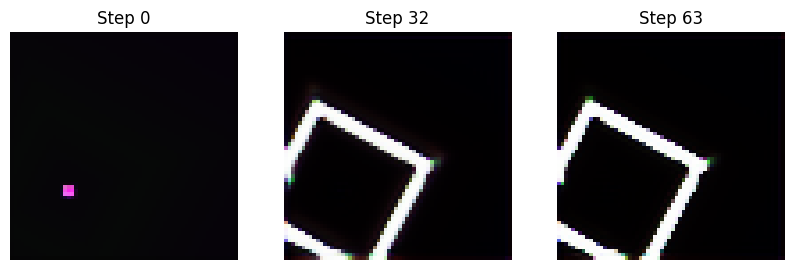

In [23]:
# 1) (a) Generalization: quick fine-tune + visualize
_ = rollout_training_param(model, cfg, optimizer, iters=400)
render_growth_param(model, cfg, shape_id=1, scale=1.2, theta=0.3, steps=64, seed=1)


[Chem] it=1/300 | loss=4.9562 | loss_rgb=0.9858 | alive_sup=5.5302
[Chem] it=100/300 | loss=0.1180 | loss_rgb=0.1010 | alive_sup=0.0254
[Chem] it=200/300 | loss=0.0220 | loss_rgb=0.0079 | alive_sup=0.0205
[Chem] it=300/300 | loss=0.0216 | loss_rgb=0.0045 | alive_sup=0.0115


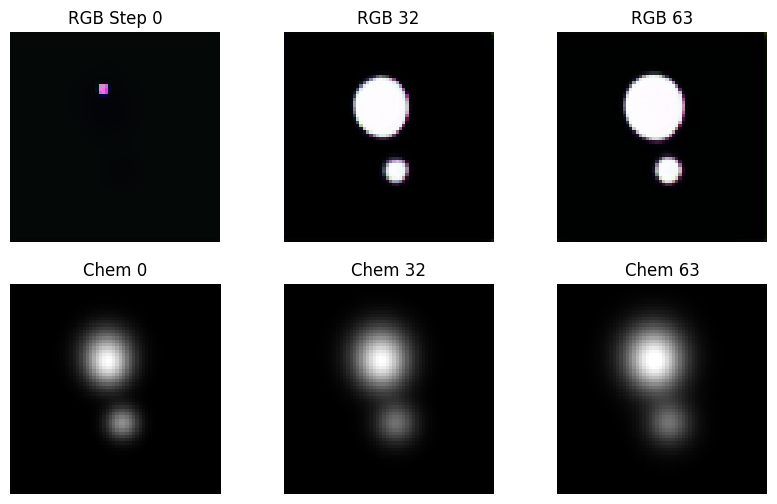

In [24]:
# 2) (b) Chemical steering: fine-tune + visualize
_ = rollout_training_chem(model, cfg, optimizer, iters=300, chem_params=ChemParams(n_sources=2))
render_growth_chem(model, cfg, steps=64, chem_params=ChemParams(n_sources=3, threshold=0.3), seed=7)




[ASAL] env 10/40 | novelty=11.254 | D=0.206 decay=0.029 src=1 thr=0.39
[ASAL] env 20/40 | novelty=0.594 | D=0.166 decay=0.009 src=1 thr=0.29
[ASAL] env 30/40 | novelty=3.218 | D=0.336 decay=0.014 src=1 thr=0.34
[ASAL] env 40/40 | novelty=5.493 | D=0.200 decay=0.015 src=2 thr=0.34


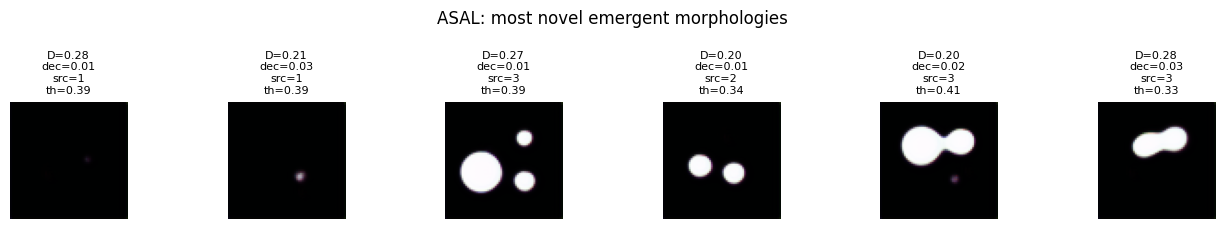

[ASAL-train] env 1/6
[Chem] it=1/120 | loss=0.0138 | loss_rgb=0.0044 | alive_sup=0.0130
[Chem] it=100/120 | loss=0.0102 | loss_rgb=0.0035 | alive_sup=0.0096
[ASAL-train] env 2/6
[Chem] it=1/120 | loss=0.0141 | loss_rgb=0.0049 | alive_sup=0.0124
[Chem] it=100/120 | loss=0.0052 | loss_rgb=0.0015 | alive_sup=0.0046
[ASAL-train] env 3/6
[Chem] it=1/120 | loss=0.2237 | loss_rgb=0.0385 | alive_sup=0.0683
[Chem] it=100/120 | loss=0.0315 | loss_rgb=0.0070 | alive_sup=0.0222
[ASAL-train] env 4/6
[Chem] it=1/120 | loss=0.1051 | loss_rgb=0.0296 | alive_sup=0.0970
[Chem] it=100/120 | loss=0.0094 | loss_rgb=0.0032 | alive_sup=0.0083
[ASAL-train] env 5/6
[Chem] it=1/120 | loss=0.1064 | loss_rgb=0.0287 | alive_sup=0.1214
[Chem] it=100/120 | loss=0.0086 | loss_rgb=0.0027 | alive_sup=0.0072
[ASAL-train] env 6/6
[Chem] it=1/120 | loss=0.8061 | loss_rgb=0.1849 | alive_sup=0.8596
[Chem] it=100/120 | loss=0.0397 | loss_rgb=0.0143 | alive_sup=0.0375
ASAL curriculum fine-tune complete.


In [27]:
# 3) (c) ASAL search + optional curriculum
winners = asal_search(model, cfg, num_envs=40, steps=64, top_k=6)
finetune_on_asal_winners(model, cfg, optimizer, winners, iters_per_env=120, steps=64)